In [2]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, PredefinedSplit
from sklearn.feature_extraction import DictVectorizer
from scipy.stats import uniform, randint
from matplotlib import pyplot as plt
from helpers import *

In [3]:
# path to project directory
path = Path('./')

In [4]:
# read in training dataset
train_df = pd.read_csv(path/'data/train_v4.csv', index_col=0, dtype={'season':str})

## XGBoost model

XGboost is a ensemble tree-based predictive algorithm that performs well across a range of applications. Applying it to a time series problem, where metrics from recent time periods can be predicitve, requires us to add in window features (e.g. points scored last gameweek). These are created using the player_lag_features function from 00_fpl_features.

In [25]:
# add a bunch of player lag features
lag_train_df, team_lag_vars = team_lag_features(train_df, ['total_points'], ['all', 1, 2, 3, 4, 5, 10])
lag_train_df, player_lag_vars = player_lag_features(lag_train_df, ['total_points'], ['all', 1, 2, 3, 4, 5, 10])

We have introduced a number of lag (window) features for each player's points per game, their team's points per game and the opposition team's points per game over the previous 1, 2, 3, 4, 5, 10 and all gameweeks.

Next we can set the validation point and length as well as the categorical and continuous features we'll be using to predict the dependent variable, total points for each game. These are used in the create_lag_train function to get an our training set (including appropriate lag values in the validation set).

The gameweeks and seasons are ordered, so we want to have them as ordered categories with the correct order (2016-17 is before 2017-18 etc.).

In [26]:
# set validaton point/length and categorical/continuous variables
valid_season = '1920'
valid_gw = 20
valid_len = 6
# cat_vars = ['season', 'position', 'team', 'opponent_team', 'was_home']
cat_vars = ['season', 'position', 'was_home']
cont_vars = ['gw', 'minutes']
dep_var = ['total_points']

In [27]:
cat_vars = cat_vars + ['minutes_last_all', 
                       'minutes_last_1', 
                       'minutes_last_2', 
                       'minutes_last_3', 
                       'minutes_last_4', 
                       'minutes_last_5', 
                       'minutes_last_10']

In [28]:
# we want to set gw and season as ordered categorical variables
# need lists with ordered categories
ordered_gws = list(range(1,39))
ordered_seasons = ['1617', '1718', '1819', '1920']

# set as categories with correct order 
lag_train_df['gw'] = lag_train_df['gw'].astype('category')
lag_train_df['season'] = lag_train_df['season'].astype('category')

lag_train_df['gw'].cat.set_categories(ordered_gws, ordered=True, inplace=True)
lag_train_df['season'].cat.set_categories(ordered_seasons, ordered=True, inplace=True)

In [29]:
# create dataset with adjusted post-validation lag numbers
lag_train_df, train_idx, valid_idx = create_lag_train(lag_train_df, 
                                                      cat_vars, cont_vars, 
                                                      player_lag_vars, team_lag_vars, dep_var,
                                                      valid_season, valid_gw, valid_len)

In [30]:
# take a look at the dataframe
lag_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82054 entries, 0 to 82053
Data columns (total 38 columns):
 #   Column                                  Non-Null Count  Dtype   
---  ------                                  --------------  -----   
 0   index                                   82054 non-null  int64   
 1   position                                82054 non-null  int64   
 2   minutes_last_2                          82054 non-null  float64 
 3   minutes_last_all                        82054 non-null  int64   
 4   minutes_last_4                          82054 non-null  float64 
 5   season                                  82054 non-null  category
 6   team                                    82054 non-null  object  
 7   minutes_last_1                          82054 non-null  float64 
 8   minutes_last_5                          82054 non-null  float64 
 9   minutes_last_10                         82054 non-null  float64 
 10  opponent_team                           82054 

We can now build the input (X) and dependent (y) variable datasets. This includes encoding the categorical features so that each level is represented in it's own column (e.g. postition_1, position_2, etc.).

In [31]:
# split out dependent variable
X, y = lag_train_df[cat_vars + cont_vars + player_lag_vars + team_lag_vars].copy(), lag_train_df[dep_var].copy()

In [32]:
# since position is categorical, it should be a string
X['position'] = X['position'].apply(str)

# need to transform season
enc = LabelEncoder()
X['season'] = enc.fit_transform(X['season'])
X_dict = X.to_dict("records")

# Create the DictVectorizer object: dv
dv = DictVectorizer(sparse=False, separator='_')

# Apply dv on df: df_encoded
X_encoded = dv.fit_transform(X_dict)

X_df = pd.DataFrame(X_encoded, columns=dv.feature_names_)

You can see the resulting dataset with the categorical features split out into levels. This can now be used in the XGBoost API.

In [33]:
X_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82054 entries, 0 to 82053
Data columns (total 36 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   gw                                      82054 non-null  float64
 1   minutes                                 82054 non-null  float64
 2   minutes_last_1                          82054 non-null  float64
 3   minutes_last_10                         82054 non-null  float64
 4   minutes_last_2                          82054 non-null  float64
 5   minutes_last_3                          82054 non-null  float64
 6   minutes_last_4                          82054 non-null  float64
 7   minutes_last_5                          82054 non-null  float64
 8   minutes_last_all                        82054 non-null  float64
 9   position_1                              82054 non-null  float64
 10  position_2                              82054 non-null  fl

In [34]:
X[player_lag_vars + team_lag_vars].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82054 entries, 0 to 82053
Data columns (total 21 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   total_points_pg_last_all                68666 non-null  float64
 1   total_points_pg_last_1                  37879 non-null  float64
 2   total_points_pg_last_2                  44333 non-null  float64
 3   total_points_pg_last_3                  47807 non-null  float64
 4   total_points_pg_last_4                  50292 non-null  float64
 5   total_points_pg_last_5                  52087 non-null  float64
 6   total_points_pg_last_10                 57642 non-null  float64
 7   total_points_team_pg_last_all           81297 non-null  float64
 8   total_points_team_pg_last_1             81297 non-null  float64
 9   total_points_team_pg_last_2             81297 non-null  float64
 10  total_points_team_pg_last_3             81297 non-null  fl

We can start by instatiating an XGBRegressor (since the dependent variable is continuous) and do a single train with arbitrary parameters. We split out the validation set and use it after training to create predictions and calculate the RMSE versus actuals.

In [35]:
# split out training and validation sets
X_train = X_df.iloc[train_idx]
y_train = y.iloc[train_idx]
X_test = X_df.iloc[valid_idx]
y_test = y.iloc[valid_idx]

In [36]:
# instatiate and train XGB Regressor
# print result
xg_reg = xgb.XGBRegressor(gamma=0.05, learning_rate=0.08, max_depth=5, n_estimators=75, subsample=0.7)

xg_reg.fit(X_train, y_train)
preds = xg_reg.predict(X_test)
print("RMSE: %f" % (r_mse(preds, y_test['total_points'])))

RMSE: 1.781371


In [38]:
max(preds)
# thinking about whether we should include 0 minute rows in training and/or validation

8.005232

This is a clear improvement on the baseline approach, but perhaps it can be improved by doing a parameter search.

To do this we will first define the grid of parameters to be searched.

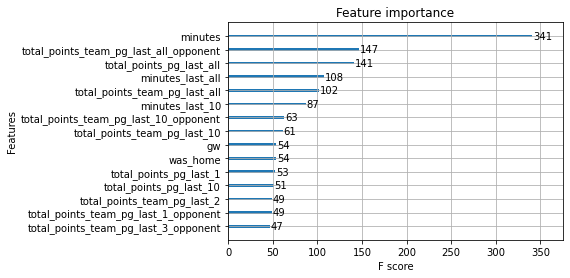

In [37]:
xgb.plot_importance(xg_reg, max_num_features=15)
plt.show()

In [23]:
# parameter search space
params = {#"colsample_bytree": uniform(0.7, 0.3),
          "gamma": uniform(0, 0.5),
          "learning_rate": uniform(0.003, 0.3), # default 0.1 
          "max_depth": randint(2, 6), # default 3
          "n_estimators": randint(25, 200), # default 100
          "subsample": uniform(0.6, 0.4)}

In this case we will pass both train and validation parts of the dataset, along with a series telling the XGBRegressor object which rows to use for training, and which for validation.

In [24]:
X_train = X_df
y_train = y
test_fold = np.repeat([-1, 0], [valid_idx[0], valid_idx[-1] - valid_idx[0] + 1])
ps = PredefinedSplit(test_fold)

We can then again instatiate the XGBRegressor object, but this time pass it to a randomised search validation object, along with the parameter grid, validation splits, and number of iterations we want to run.

We then fit this to the training data - 25 random parameter selections will be made and the best parameters for the validation set can be found (may take a few minutes to run).

In [25]:
# Instantiate the regressor: gbm
gbm = xgb.XGBRegressor(objective="reg:squarederror")

# Perform random search: grid_mse
randomized_mse = RandomizedSearchCV(estimator=gbm, 
                            param_distributions=params, 
                            scoring="neg_mean_squared_error", 
                            n_iter=25, 
                            cv=ps, 
                            verbose=1)

# Fit randomized_mse to the data
randomized_mse.fit(X_train, y_train)

# Print the best parameters and lowest RMSE
print("Best parameters found: ", randomized_mse.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(randomized_mse.best_score_)))

Fitting 1 folds for each of 25 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed: 10.0min finished


Best parameters found:  {'gamma': 0.2146060453333879, 'learning_rate': 0.14837507572239364, 'max_depth': 3, 'n_estimators': 173, 'subsample': 0.6047893424365975}
Lowest RMSE found:  1.7867114661911265


A slight improvement on the above.

In [ ]:
# Create the parameter grid: gbm_param_grid 
gbm_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [2, 3, 5],
    #'colsample_bytree': [0.1, 0.5, 0.8, 1],
    'learning_rate': [0.1]
}